In [19]:
from Classifier.load_data import read_arduino, process_data, read_arduinbro, load_training_data
from Classifier.classifier import (streaming_classifier,
                                   three_pronged_smoothing_classifier,
                                   two_pronged_smoothing_classifier,
                                   one_pronged_smoothing_classifier,
                                   zeroes_classifier,
                                   catch22_knn_classifier)

from copy import deepcopy
# from Levenshtein import distance as levenshtein_distance
from scipy import signal
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
import wave, struct



import numpy.lib.stride_tricks



In [20]:
time_buffers = {"data3":(-0.1, 1.3),
                "data2":(-0.2, 1.4),
                "data0":(-0.1, 1.3),
                "data1":(-0.3, 1.4),
                "data5":(-0.4, 1.3),
                "data4":(-0.2, 1.3)}

In [4]:
"""
from numba import njit

@njit
"""
def get_event_regions(wav_array, samprate, labels_dat, time_buffer):
    
    before_buffer = time_buffer[0]
    after_buffer = time_buffer[1]
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    event_bool = left_events_bool | right_events_bool
    return event_bool

#@njit


def get_test_stats(wav_array, window_size, step, test_stat_fns):
    test_stats = np.zeros((len(test_stat_fns), len(wav_array)))
        
    all_windows = numpy.lib.stride_tricks.sliding_window_view(wav_array, window_shape = window_size)

    all_windows = all_windows[::step, :]
    
    for i, fn in enumerate(test_stat_fns):
        if i == "Smoothed Zero Crossings jasdkjabdskjabsdkjsakjbd":
            testicles = np.apply_along_axis(fn, -1, all_windows, window_size)
        else:   
            testicles = np.apply_along_axis(fn, -1, all_windows)
        for j, teste in enumerate(testicles):
            if j == len(testicles)-1:
                test_stats[i, (j*step)::]  = teste
            else:
                test_stats[i, (j*step):((j+1)*step)]  = teste
    return test_stats




        
    
def get_contrast(wav_array, samprate, labels_dat, window_size, step, test_stat_fns, contrast_fn, time_buffer):
    test_stats = get_test_stats(wav_array, window_size, step, test_stat_fns)
    
    events_bool = get_event_regions(wav_array, samprate, labels_dat, time_buffer)

    event_test_stats = test_stats[:, events_bool]           
    non_event_test_stats = test_stats[:, ~events_bool]
    
    
    contrast_stat = contrast_fn(event_test_stats, non_event_test_stats)
    
    return contrast_stat
    
    
    
def contrast_all_files(window_size, 
                       test_stat_fns,
                       samprate,     
                       waves,        
                       labels,       
                       contrast_fn,
                       step=0.1):   
    
    step = int(step*samprate)
    start = time.time()
    
    for i, key in enumerate(waves.keys()):
        wav_array = waves[key]
        labels_dat = labels[key]
        
        cont = get_contrast(wav_array, samprate, labels_dat,
                         window_size, step, test_stat_fns,
                         contrast_fn, time_buffers[key])
        
        with open("event_detection_optimisation.csv", "a") as file:
            file.write(",".join([str(window_size), key]) + "," + ','.join(np.round(cont, 4).astype(str)) + "\n")

         

In [5]:
# Define Test Stat Functions

def ts_smooth_zero_crossings(x, window_length = 100):
    filtered_x = signal.savgol_filter(x, window_length, 1)
    return np.sum(filtered_x[0:-1]*filtered_x[1::] <= 0)
def ts_range(x): 
    return np.max(x) - np.min(x)
def ts_IQR(x): 
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)
def ts_abs_max(x): 
    return np.max(np.abs(x))
def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)
def max_frequency(frame, samprate=10000):
    fs = samprate
    dt = 1/fs
    t = np.arange(0, (len(frame)*dt), dt)

    # Num samples
    N = len(frame)

    yf = fft(frame)
    xf = fftfreq(N, 1/fs)
    np.size(xf)
    np.size(t)

    f, t, Sxx = signal.spectrogram(frame, fs)
    maximum = np.max(Sxx)
    threshold = maximum/5;
    maximum_Freqs = np.amax(Sxx, 0) # max frequency for each time

    return np.amax(maximum_Freqs)



In [6]:
waves, labels, samprate = load_training_data(path = "Datasets/",
                                             scale_factor= 1,
                                             blacklist = ["data0"],
                                             whitelist = ["data"])

samprate = 10_000




dict_keys(['data0', 'data1', 'data2', 'data3', 'data4', 'data5']) dict_keys(['data0', 'data1', 'data2', 'data3', 'data4', 'data5'])
c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\Classifier\load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [ ]:

"""
labels1 = np.array([])
waves1 = []
i = 0
for key in waves.keys():
    waves1.append(list(waves[key]))
print(type(waves1))
print(type(waves1[1]))
print(type(waves1[1][1]))
waves1 = np.ndarray(waves1, np.float64)
print(waves1[1])
print(len(waves1))
print(len(waves1[5]))
"""

tfn_candidates = {"Range": ts_range,
                  "IQR": ts_IQR,
                  "SD": np.std,
                  "Absolute Max": ts_abs_max,
                  "Zero Crossings": ts_zero_crossings,
                  "Fourier": max_frequency}


def contrast(x, y): 
    pooled_sd = np.sqrt(np.var(x)/len(x) + np.var(y)/len(y))
    return (np.mean(x, axis=1) - np.mean(y, axis=1))/pooled_sd

open("event_detection_optimisation.csv", 'w').close()    # Clears the file so that the code can be run again.


contrasts = []
for x in np.linspace(100, 20000, 200):
    x = int(x)
    print(x)
    contrast_all_files(window_size = x, 
                           test_stat_fns = tfn_candidates.values(),
                           samprate = samprate,
                           waves = waves,
                           labels = labels,
                           step = 0.1,
                           contrast_fn = contrast
                      )


100
C:\Users\darap\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '
200
C:\Users\darap\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
300


KeyboardInterrupt: 

In [25]:
contrasts = pd.read_csv("event_detection_optimisation.csv", header=None)
contrasts.columns = ["window_size", "file"] + list(tfn_candidates.keys())
contrasts

,window_size,file,Range,IQR,SD,Absolute Max,Zero Crossings,Fourier
0,100,data3,0.0249,0.0229,0.0120,3.4629,-0.6259,0.0013
1,100,data2,-0.1085,-0.1008,-0.0455,3.3193,-0.6218,-0.0045
2,100,data1,0.0388,0.0251,0.0110,3.5253,-0.8023,0.0010
3,100,data5,0.0406,-0.0111,0.0062,3.7021,-0.7009,0.0004
4,100,data4,0.0506,0.0663,0.0252,3.4734,-0.3817,0.0022
...,...,...,...,...,...,...,...,...
995,20000,data3,-0.0140,0.0003,-0.0057,0.0163,-0.1142,-0.0026
996,20000,data2,0.0161,0.0038,0.0015,0.0273,-0.5281,0.0029
997,20000,data1,0.0691,0.0087,0.0105,0.0568,-0.8103,0.0240
998,20000,data5,0.0988,0.0769,0.0318,0.0467,-1.5959,0.0431


In [26]:
contrasts_total = contrasts.groupby("window_size").mean()

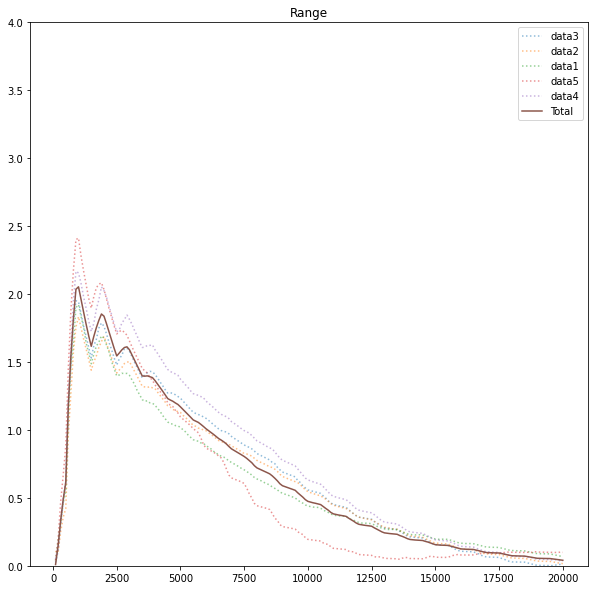

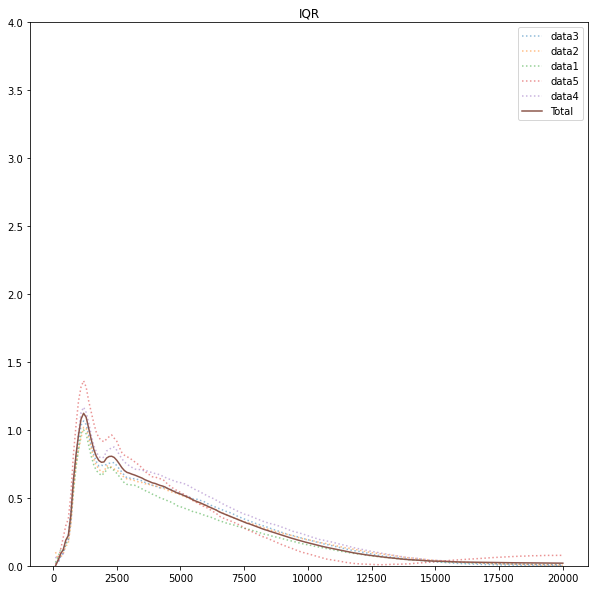

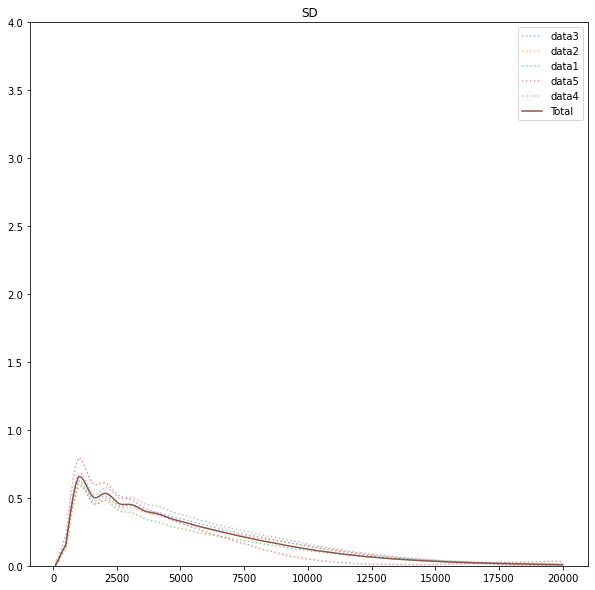

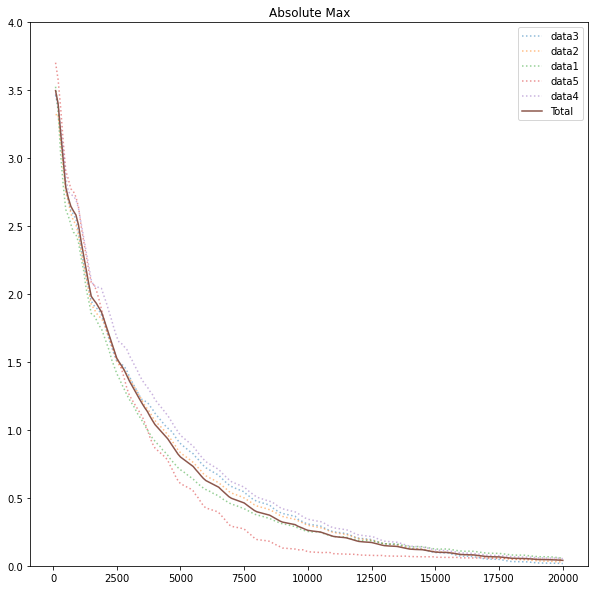

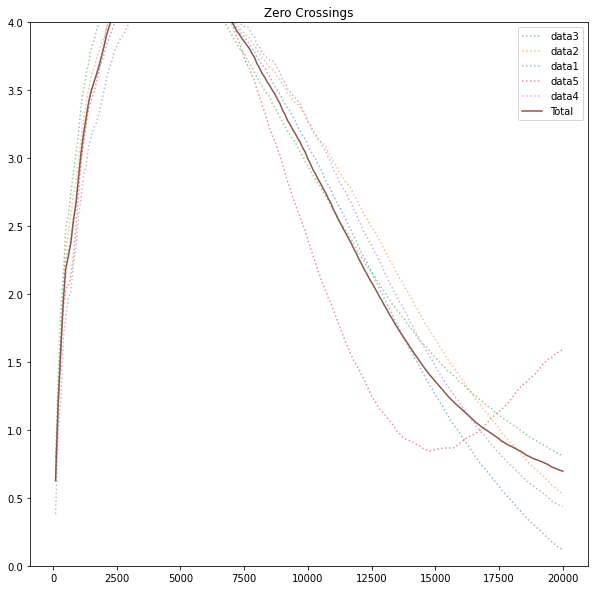

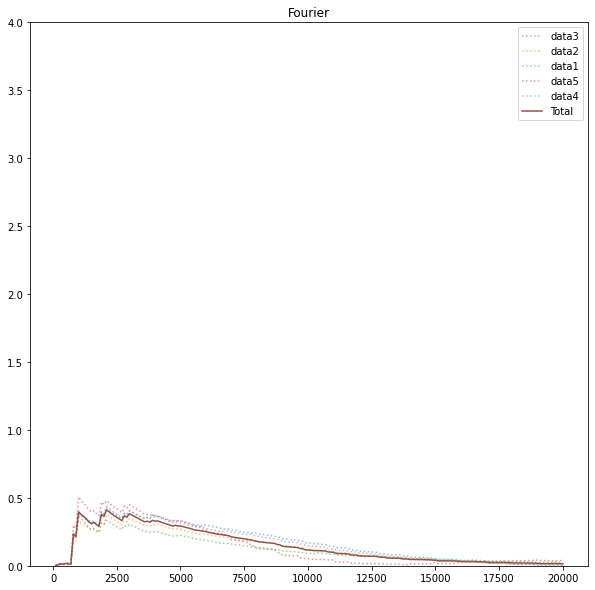

In [27]:
# plt.plot(contrasts[:, 0])
for stat in tfn_candidates.keys():
    plt.figure(figsize=(10, 10))
    plt.ylim(0, 4)
    for file in waves.keys():
        plt.plot(contrasts[contrasts.file == file].window_size,
                 np.abs(contrasts[contrasts.file == file][stat]),
                 label = file, alpha = 0.5, linestyle=":") 
    
    plt.plot(contrasts_total.index,
             np.abs(contrasts_total[stat]),
             label = "Total", alpha = 1)
    plt.legend()
    plt.title(stat)

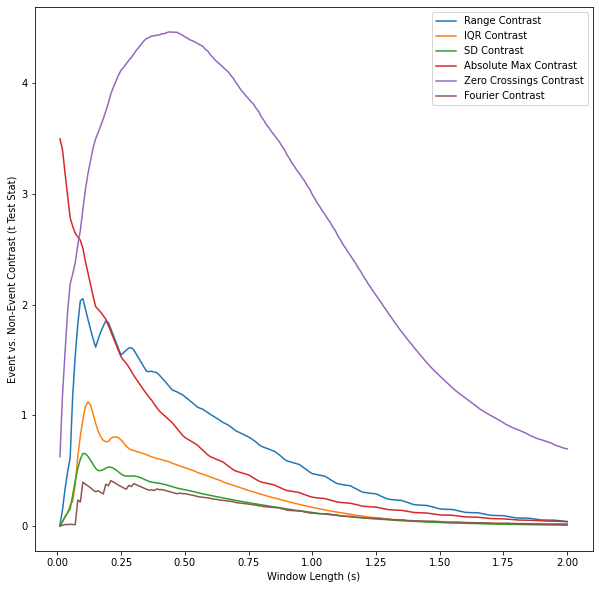

In [28]:
plt.figure(figsize=(10, 10))

for stat in tfn_candidates.keys():
    plt.plot(contrasts_total.index/samprate,
             np.abs(contrasts_total[stat]),
             label = f"{stat} Contrast", alpha = 1)

plt.title("")
plt.xlabel("Window Length (s)")    
plt.ylabel("Event vs. Non-Event Contrast (t Test Stat)")  
plt.legend()


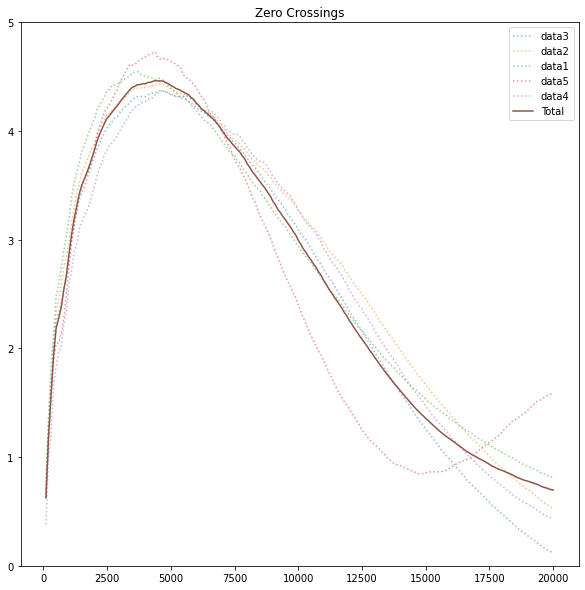

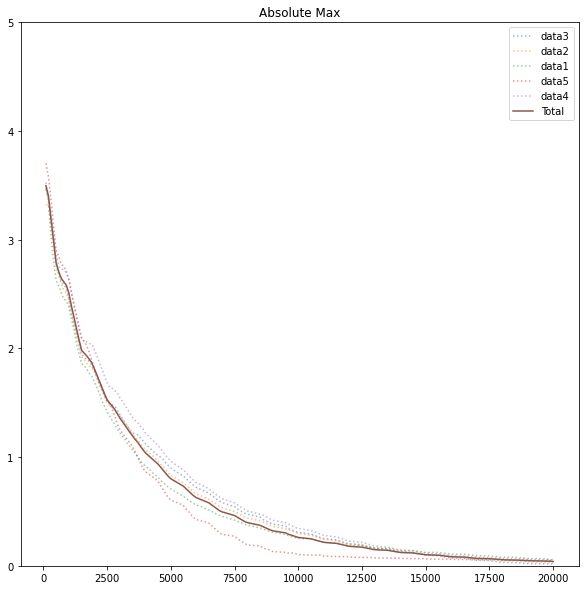

In [33]:

for stat in ["Zero Crossings", "Absolute Max"]:
    plt.figure(figsize=(10, 10))

    plt.ylim(0, 5)
    for file in waves.keys():
        plt.plot(contrasts[contrasts.file == file].window_size,
                 np.abs(contrasts[contrasts.file == file][stat]),
                 label = file, alpha = 0.5, linestyle=":") 
    
    plt.plot(contrasts_total.index,
             np.abs(contrasts_total[stat]),
             label = "Total", alpha = 1)
    plt.legend()
    plt.title(stat)

In [37]:


opt_zerocrossings = contrasts_total.index[np.argmax(np.abs(contrasts_total["Zero Crossings"]))]

opt_zerocrossings



4400

In [38]:
window_size = opt_zerocrossings/samprate
print(window_size)

0.44
